In [1]:
%load_ext autoreload
%autoreload 2
import sys
import os
import joblib
from typing import Any
sys.path.insert(0, os.path.abspath('..'))

from src.feature_engineer import load_encoder
from src.utils.model_utils import evaulate_model, train_model
from src.utils.visualize_utils import plot_cm, get_avg_fold

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

import torch.nn as nn
import torch
from torch.utils.data import DataLoader, TensorDataset

from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import StandardScaler

from scipy.spatial.transform import Rotation

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
raw_path = "../data/raw"
encoder_path = "../models/label_encoder.pkl"

In [143]:
# preprocess
full_df = pd.merge(
    left=pd.read_csv(os.path.join(raw_path, "train.csv")),
    right=pd.read_csv(os.path.join(raw_path, "train_demographics.csv")),
    on="subject",
    how="left",
)

full_df = full_df.drop(columns=[col for col in full_df.columns if col.startswith("tof_")])

full_df

,row_id,sequence_type,sequence_id,sequence_counter,subject,orientation,behavior,phase,gesture,acc_x,...,thm_3,thm_4,thm_5,adult_child,age,sex,handedness,height_cm,shoulder_to_wrist_cm,elbow_to_wrist_cm
0,SEQ_000007_000000,Target,SEQ_000007,0,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Relaxes and moves hand to target location,Transition,Cheek - pinch skin,6.683594,...,29.553024,28.592863,28.310535,0,12,1,1,163.0,52,24.0
1,SEQ_000007_000001,Target,SEQ_000007,1,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Relaxes and moves hand to target location,Transition,Cheek - pinch skin,6.949219,...,29.791740,28.663383,28.406172,0,12,1,1,163.0,52,24.0
2,SEQ_000007_000002,Target,SEQ_000007,2,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Relaxes and moves hand to target location,Transition,Cheek - pinch skin,5.722656,...,30.090014,28.796087,28.529778,0,12,1,1,163.0,52,24.0
3,SEQ_000007_000003,Target,SEQ_000007,3,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Relaxes and moves hand to target location,Transition,Cheek - pinch skin,6.601562,...,29.310717,29.018711,27.402010,0,12,1,1,163.0,52,24.0
4,SEQ_000007_000004,Target,SEQ_000007,4,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Relaxes and moves hand to target location,Transition,Cheek - pinch skin,5.566406,...,26.808746,29.408604,27.357603,0,12,1,1,163.0,52,24.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
574940,SEQ_065531_000048,Non-Target,SEQ_065531,48,SUBJ_039498,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Write name on leg,3.503906,...,27.857061,30.359417,29.501087,1,30,0,1,186.0,55,30.0
574941,SEQ_065531_000049,Non-Target,SEQ_065531,49,SUBJ_039498,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Write name on leg,3.773438,...,27.965866,30.417227,29.244358,1,30,0,1,186.0,55,30.0
574942,SEQ_065531_000050,Non-Target,SEQ_065531,50,SUBJ_039498,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Write name on leg,3.082031,...,27.893045,30.340141,29.244358,1,30,0,1,186.0,55,30.0
574943,SEQ_065531_000051,Non-Target,SEQ_065531,51,SUBJ_039498,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Write name on leg,3.964844,...,28.046608,30.397961,28.868093,1,30,0,1,186.0,55,30.0


In [186]:
non_target_gestures = full_df[full_df["sequence_type"] == "Non-Target"]["gesture"].unique()
target_gestures = full_df[full_df["sequence_type"] == "Target"]["gesture"].unique()

filtered_df = full_df[full_df["phase"] == "Gesture"]
filtered_df.loc[filtered_df["sequence_type"] == "Non-Target", "gesture"] = non_target_gestures[0]

cols_of_interest = ["rot_w", "rot_x", "rot_y", "rot_z"]

# drop na
bad_seq_id = full_df[full_df["rot_w"].isnull()]["sequence_id"].unique()
bad_seq_mask = filtered_df["sequence_id"].isin(bad_seq_id)
filtered_df = filtered_df[~bad_seq_mask]
filtered_df["rot_w"].isnull().sum()


# feature engineer
quat = filtered_df[["rot_w", "rot_x", "rot_y", "rot_z"]]
rotation_object = Rotation.from_quat(quat)
euler_angles = rotation_object.as_euler("xyz")  # N x 3
rotation_vectors = rotation_object.as_rotvec()

filtered_df["roll"] = euler_angles[:, 0]
filtered_df["pitch"] = euler_angles[:, 1]
filtered_df["yaw"] = euler_angles[:, 2]
# 
filtered_df['rotvec_x'] = rotation_vectors[:, 0]
filtered_df['rotvec_y'] = rotation_vectors[:, 1]
filtered_df['rotvec_z'] = rotation_vectors[:, 2]
filtered_df['rot_angle'] = np.linalg.norm(rotation_vectors, axis=1)

filtered_df['rotvec_x_velocity'] = filtered_df.groupby('sequence_id')['rotvec_x'].transform(lambda x: x.diff().fillna(0))
filtered_df['rotvec_y_velocity'] = filtered_df.groupby('sequence_id')['rotvec_y'].transform(lambda x: x.diff().fillna(0))
filtered_df['rotvec_z_velocity'] = filtered_df.groupby('sequence_id')['rotvec_z'].transform(lambda x: x.diff().fillna(0))
filtered_df['angular_speed'] = np.sqrt(filtered_df['rotvec_x_velocity']**2 + filtered_df['rotvec_y_velocity']**2 + filtered_df['rotvec_z_velocity']**2)

filtered_df

,row_id,sequence_type,sequence_id,sequence_counter,subject,orientation,behavior,phase,gesture,acc_x,...,pitch,yaw,rotvec_x,rotvec_y,rotvec_z,rot_angle,rotvec_x_velocity,rotvec_y_velocity,rotvec_z_velocity,angular_speed
25,SEQ_000007_000025,Target,SEQ_000007,25,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Cheek - pinch skin,7.027344,...,0.757346,0.887347,-0.543028,0.609165,0.927352,1.235290,0.000000,0.000000,0.000000,0.000000
26,SEQ_000007_000026,Target,SEQ_000007,26,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Cheek - pinch skin,6.984375,...,0.748771,0.848585,-0.546858,0.599843,0.898660,1.210973,-0.003831,-0.009322,-0.028692,0.030410
27,SEQ_000007_000027,Target,SEQ_000007,27,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Cheek - pinch skin,7.027344,...,0.734910,0.892565,-0.514167,0.597047,0.924279,1.214547,0.032691,-0.002796,0.025619,0.041628
28,SEQ_000007_000028,Target,SEQ_000007,28,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Cheek - pinch skin,6.488281,...,0.767080,0.984522,-0.463462,0.658639,0.970921,1.261463,0.050705,0.061592,0.046642,0.092412
29,SEQ_000007_000029,Target,SEQ_000007,29,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Cheek - pinch skin,6.988281,...,0.775313,1.004290,-0.448789,0.676450,0.977821,1.270877,0.014674,0.017812,0.006900,0.024087
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
574940,SEQ_065531_000048,Non-Target,SEQ_065531,48,SUBJ_039498,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Write name on leg,3.503906,...,0.370584,-3.097535,-0.306049,2.475549,1.351382,2.836942,0.026447,0.060566,-0.035032,0.074799
574941,SEQ_065531_000049,Non-Target,SEQ_065531,49,SUBJ_039498,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Write name on leg,3.773438,...,0.396273,-3.097932,-0.315238,2.466755,1.312100,2.811736,-0.009189,-0.008794,-0.039282,0.041290
574942,SEQ_065531_000050,Non-Target,SEQ_065531,50,SUBJ_039498,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Write name on leg,3.082031,...,0.402295,-3.095545,-0.322197,2.460795,1.313119,2.807776,-0.006959,-0.005960,0.001019,0.009219
574943,SEQ_065531_000051,Non-Target,SEQ_065531,51,SUBJ_039498,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Write name on leg,3.964844,...,0.428240,-3.094489,-0.332287,2.451331,1.274430,2.782735,-0.010090,-0.009463,-0.038689,0.041088


In [187]:
agg_recipe = {
    "gesture": ["first"],
    "subject": ["first"],
    # eigen chad
    "rotvec_x": ["mean", "std"],
    "rotvec_y": ["mean", "std"],
    "rotvec_z": ["mean", "std"],
    "rot_angle": ["mean", "std"],
    # angular velocity
    "rotvec_x_velocity": ["mean", "std", "min", "max"],
    "rotvec_y_velocity": ["mean", "std", "min", "max"],
    "rotvec_z_velocity": ["mean", "std", "min", "max"],
    "angular_speed": ["mean", "std", "max"],
}

filtered_df = filtered_df.groupby("sequence_id")[list(agg_recipe.keys())].agg(agg_recipe)  # type: ignore
filtered_df.columns = ["_".join(col).strip() if col[1] else col[0] for col in filtered_df.columns.values]
filtered_df = filtered_df.rename(
    columns={
        "gesture_first": "target",
        "subject_first": "subject",
    }
)

# encoder
target_df = filtered_df["target"]
subject_df = filtered_df["subject"]
encoder = load_encoder(encoder_path, target_df)

target_tensor = torch.tensor(encoder.transform(target_df), dtype=torch.long)
features_tensor = torch.tensor(filtered_df.drop(columns=["target", "subject"]).to_numpy(), dtype=torch.float32)
target_gestures_encoded = torch.tensor(encoder.transform(target_gestures))

filtered_df

,target,subject,rotvec_x_mean,rotvec_x_std,rotvec_y_mean,rotvec_y_std,rotvec_z_mean,rotvec_z_std,rot_angle_mean,rot_angle_std,...,rotvec_y_velocity_std,rotvec_y_velocity_min,rotvec_y_velocity_max,rotvec_z_velocity_mean,rotvec_z_velocity_std,rotvec_z_velocity_min,rotvec_z_velocity_max,angular_speed_mean,angular_speed_std,angular_speed_max
sequence_id,,,,,,,,,,,,,,,,,,,,,
SEQ_000007,Cheek - pinch skin,SUBJ_059520,-0.491419,0.088411,0.646820,0.130625,0.920630,0.075947,1.237257,0.080723,...,0.076592,-0.165974,0.249411,-0.001624,0.031514,-0.062096,0.060664,0.070060,0.057291,0.257446
SEQ_000008,Forehead - pull hairline,SUBJ_020948,-0.481945,0.051845,0.191723,0.059166,0.908953,0.169366,1.058416,0.095239,...,0.073797,-0.165550,0.132388,-0.022316,0.128292,-0.432939,0.203918,0.134260,0.089409,0.472864
SEQ_000013,Cheek - pinch skin,SUBJ_040282,1.419351,0.117953,0.763822,0.086338,2.507355,0.097212,2.985374,0.047049,...,0.053439,-0.080833,0.124918,-0.004182,0.044188,-0.088621,0.069707,0.072358,0.033661,0.155866
SEQ_000016,Write name on leg,SUBJ_052342,-0.978995,0.028443,2.326376,0.431889,0.863376,0.255317,2.682087,0.415276,...,0.216427,-1.226315,0.056397,-0.031476,0.119609,-0.644856,0.141641,0.087070,0.238864,1.385826
SEQ_000018,Forehead - pull hairline,SUBJ_032165,-2.381709,0.035173,-0.771175,0.041772,1.220128,0.044562,2.785772,0.016233,...,0.027531,-0.117244,0.040550,-0.001971,0.021128,-0.054488,0.046853,0.029357,0.023908,0.119186
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SEQ_065508,Write name on leg,SUBJ_027682,0.286483,0.039557,-1.125245,0.032410,1.481904,0.021156,1.883240,0.026151,...,0.036782,-0.085839,0.087138,0.001174,0.012087,-0.029251,0.030381,0.037819,0.025473,0.109441
SEQ_065519,Neck - scratch,SUBJ_050642,-0.027254,0.178825,0.113071,0.080225,1.889328,0.028813,1.902616,0.033410,...,0.038015,-0.142894,0.059673,-0.002474,0.018141,-0.056134,0.042012,0.057407,0.054884,0.239711
SEQ_065522,Above ear - pull hair,SUBJ_040282,1.258610,0.059650,-1.674419,0.047494,0.974436,0.069383,2.312136,0.040740,...,0.065779,-0.100036,0.112381,0.010305,0.045997,-0.074326,0.101518,0.087279,0.034718,0.179581


([0, 1, 2, 3, 4, 5, 6, 7, 8],
 [Text(0, 0, 'Cheek - pinch skin'),
  Text(1, 0, 'Forehead - pull hairline'),
  Text(2, 0, 'Write name on leg'),
  Text(3, 0, 'Neck - scratch'),
  Text(4, 0, 'Neck - pinch skin'),
  Text(5, 0, 'Eyelash - pull hair'),
  Text(6, 0, 'Eyebrow - pull hair'),
  Text(7, 0, 'Forehead - scratch'),
  Text(8, 0, 'Above ear - pull hair')])

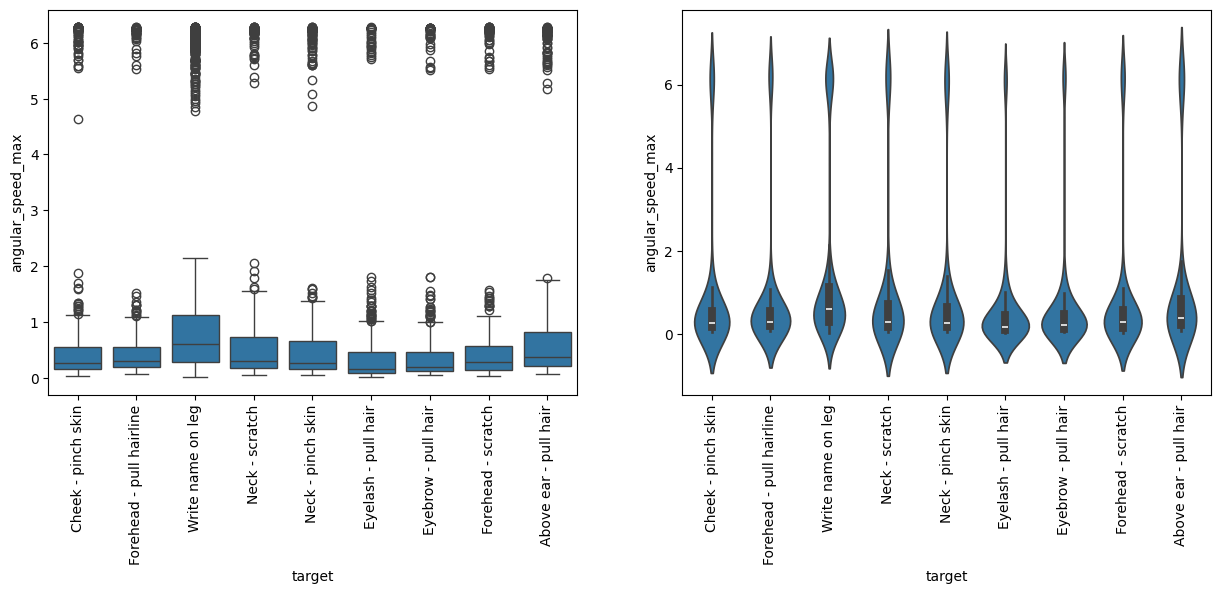

In [188]:
feature_name = 'angular_speed_max'
plt.figure(figsize=(15, 5))
plt.subplot(121)
sns.boxplot(filtered_df, x='target', y=feature_name)
plt.xticks(rotation=90)

plt.subplot(122)
sns.violinplot(filtered_df, x='target', y=feature_name)
plt.xticks(rotation=90)

In [189]:
class SimpleModel(nn.Module):
    def __init__(self, n_input, n_classes):
        super().__init__()

        self.fc = nn.Sequential(
            nn.Linear(n_input, 100),
            nn.ReLU(),
            nn.Linear(100, 50),
            nn.ReLU(),
            nn.Linear(50, n_classes),
        )

    def forward(self, x: torch.Tensor):
        y_pred = self.fc(x)

        return y_pred

In [190]:
batch_size = 64
n_epochs = 200
n_splits = 5

gkf = GroupKFold(n_splits)

test_subjects = []
folds_score = []
for fold, (train_indices, test_indices) in enumerate(gkf.split(X=features_tensor, y=target_tensor, groups=subject_df)): # type: ignore
    test_subjects.append(subject_df[test_indices].unique())
    X_train, y_train = features_tensor[train_indices], target_tensor[train_indices]
    X_test, y_test = features_tensor[test_indices], target_tensor[test_indices]
    
    scalar = StandardScaler()
    X_train = torch.tensor(scalar.fit_transform(X_train.numpy()), dtype=torch.float32)
    X_test = torch.tensor(scalar.transform(X_test), dtype=torch.float32)
    
    dataset_train = TensorDataset(X_train, y_train)
    dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True) # uh not sure if i should keep shuffle or no
    
    model = SimpleModel(X_train.shape[1], len(encoder.classes_)).to(device)
    
    model.train()
    train_model(model, dataloader_train, n_epochs, True)

    model.eval()
    score_dashboard = evaulate_model(model, X_test, y_test, target_gestures_encoded, encoder)
    folds_score.append(score_dashboard)

/tmp/ipykernel_14302/1917683516.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_subjects.append(subject_df[test_indices].unique())


0 - loss_avg: 1.9099738352438982
20 - loss_avg: 1.2266105103726481
40 - loss_avg: 1.0876826731597675
60 - loss_avg: 0.9934088348173628
80 - loss_avg: 0.9326864954303292
100 - loss_avg: 0.8822809229878819
120 - loss_avg: 0.8443543630487779
140 - loss_avg: 0.8066992987604702
160 - loss_avg: 0.7843904898447149
180 - loss_avg: 0.7594974076046663


/tmp/ipykernel_14302/1917683516.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_subjects.append(subject_df[test_indices].unique())


0 - loss_avg: 1.948760728041331
20 - loss_avg: 1.2597051590096717
40 - loss_avg: 1.1267710427443187
60 - loss_avg: 1.0478897217442007
80 - loss_avg: 0.9840528497508928
100 - loss_avg: 0.9335692110014897
120 - loss_avg: 0.8858264065256306
140 - loss_avg: 0.8554157188125685
160 - loss_avg: 0.8157295777517206
180 - loss_avg: 0.7950105813204074


/tmp/ipykernel_14302/1917683516.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_subjects.append(subject_df[test_indices].unique())


0 - loss_avg: 1.9427234530448914
20 - loss_avg: 1.2397740383942921
40 - loss_avg: 1.1064324092631246
60 - loss_avg: 1.0169040286073499
80 - loss_avg: 0.9526783122735865
100 - loss_avg: 0.899965903338264
120 - loss_avg: 0.8531578785064173
140 - loss_avg: 0.814645894017874
160 - loss_avg: 0.7848995894778008
180 - loss_avg: 0.7529034149997375


/tmp/ipykernel_14302/1917683516.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_subjects.append(subject_df[test_indices].unique())


0 - loss_avg: 1.8510317814116384
20 - loss_avg: 1.1822107656329286
40 - loss_avg: 1.0436564830004
60 - loss_avg: 0.9575423037304598
80 - loss_avg: 0.8976320548384797
100 - loss_avg: 0.8501891563920414
120 - loss_avg: 0.8072515828352348
140 - loss_avg: 0.7862096259406969
160 - loss_avg: 0.7393530984135235
180 - loss_avg: 0.7253328360178891


/tmp/ipykernel_14302/1917683516.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_subjects.append(subject_df[test_indices].unique())


0 - loss_avg: 1.9255343465244068
20 - loss_avg: 1.2887398238275565
40 - loss_avg: 1.1423845489819844
60 - loss_avg: 1.0482322661315693
80 - loss_avg: 0.9766141748895832
100 - loss_avg: 0.9284508479576484
120 - loss_avg: 0.8870909465294258
140 - loss_avg: 0.8487834889514774
160 - loss_avg: 0.8274423667028838
180 - loss_avg: 0.8139820817638846


macro: 0.40, binary: 0.91, competition: 0.65


,precision,recall,f1-score,support
Above ear - pull hair,0.394799,0.391443,0.387659,126.800000
Cheek - pinch skin,0.311519,0.260675,0.281515,126.600000
Eyebrow - pull hair,0.284070,0.219196,0.243308,126.800000
Eyelash - pull hair,0.406181,0.377604,0.388377,127.200000
Forehead - pull hairline,0.385942,0.426240,0.397785,127.200000
Forehead - scratch,0.469199,0.575546,0.504535,127.200000
Neck - pinch skin,0.265773,0.201290,0.227804,127.200000
Neck - scratch,0.282647,0.287351,0.281176,126.800000
Write name on leg,0.836496,0.871584,0.853146,604.200000
accuracy,0.539799,0.539799,0.539799,0.539799


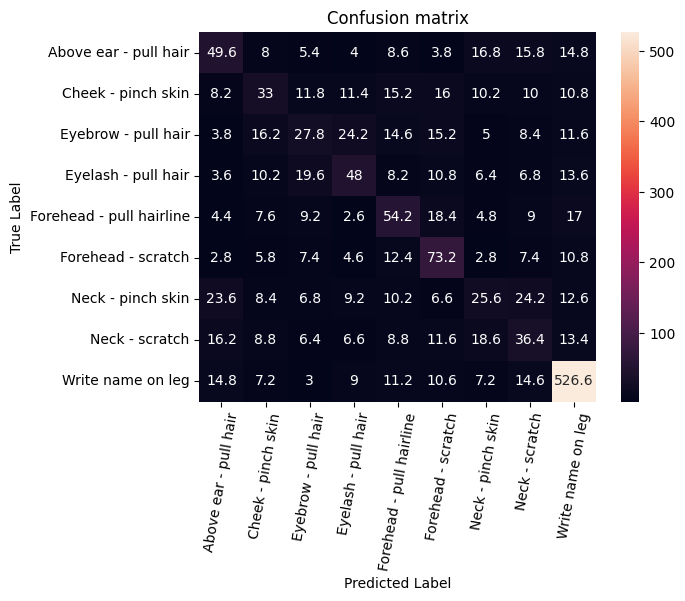

In [191]:
fold = get_avg_fold(folds_score)
# fold = folds_score[0]

macro = fold["f1_macro"]
binary = fold["f1_binary"]
competition_eval = fold["competition_evaluation"]
cm = fold['confusion_matrix']

print(f'macro: {macro:.2f}, binary: {binary:.2f}, competition: {competition_eval:.2f}')


plot_cm(cm, list(encoder.classes_))
fold["classification_report"]

In [ ]:
# final train model
n_epochs = 400
model = SimpleModel(len(encoder.classes_))

dataset_all = TensorDataset(features_tensor, target_tensor)
dataloader_all = DataLoader(dataset_all, batch_size=batch_size, shuffle=True)

train_model(model, dataloader_all, n_epochs, should_log=True)
torch.save(model.state_dict, '../models/model.pth')

0 - loss_avg: 1.7670864285901189
20 - loss_avg: 1.3435163935646415
40 - loss_avg: 1.2941331644542515
60 - loss_avg: 1.2580602089874446
80 - loss_avg: 1.2367916163057089
100 - loss_avg: 1.2189869447611272
120 - loss_avg: 1.2041548932902515
140 - loss_avg: 1.1891458523459733
160 - loss_avg: 1.1784265250898898
180 - loss_avg: 1.1631644000299275
200 - loss_avg: 1.1489455755800009
220 - loss_avg: 1.1393039487302303
240 - loss_avg: 1.130943219177425
260 - loss_avg: 1.1241767010651529
280 - loss_avg: 1.1117427400313318
300 - loss_avg: 1.1023416174575686
320 - loss_avg: 1.0911986152641475
340 - loss_avg: 1.0916559724137187
360 - loss_avg: 1.0821397854015231
380 - loss_avg: 1.0796014992520213
